# Process of Benchmarking data

In [1]:
from functions import averageOfFidelity, stdOfFidelity, decay_param, decay_func
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
from scipy.optimize import curve_fit

In [3]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [4]:
n_qubit = 2
noise_model = 'depolarising_noise'
path = os.path.join( os.getcwd(), 'output_storage', noise_model )

In [5]:
avg_std_fdlty_dict = {}
err_std_fdlty_dict = {}

avg_rng_fdlty_dict = {}
err_rng_fdlty_dict = {}

ordered_layers_dict = {}

In [6]:
def capture_bench_depolarising_noise_arrays(epsilon):
    folder_name = 'epsilon{}'.format(epsilon)
    # folder_name = 'x_direction'
    path = os.path.join( os.getcwd(), 'output_storage', noise_model, folder_name )

    ordered_layers = np.load(os.path.join(path, 'layers_indices.npy'))

    avg_std_fdlty_arr = np.load(os.path.join(path, 'rb_standard_50_avg_layers.npy'))
    err_std_fdlty_arr = np.load(os.path.join(path, 'rb_standard_50_err_layers.npy'))

    avg_rng_fdlty_arr = np.load(os.path.join(path, 'rb_native_standard_50_avg_layers.npy'))
    err_rng_fdlty_arr = np.load(os.path.join(path, 'rb_native_standard_50_err_layers.npy'))
    return avg_std_fdlty_arr,err_std_fdlty_arr,avg_rng_fdlty_arr,err_rng_fdlty_arr,ordered_layers


In [7]:
for epsilon in [0.001,0.002,0.004,0.006,0.008]:
    avg_std_fdlty_arr,err_std_fdlty_arr,avg_rng_fdlty_arr,err_rng_fdlty_arr,ordered_layers = capture_bench_depolarising_noise_arrays(epsilon)
    avg_std_fdlty_dict[epsilon] = avg_std_fdlty_arr
    err_std_fdlty_dict[epsilon] = err_std_fdlty_arr
    avg_rng_fdlty_dict[epsilon] = avg_rng_fdlty_arr
    err_rng_fdlty_dict[epsilon] = err_rng_fdlty_arr
    ordered_layers_dict[epsilon] = ordered_layers

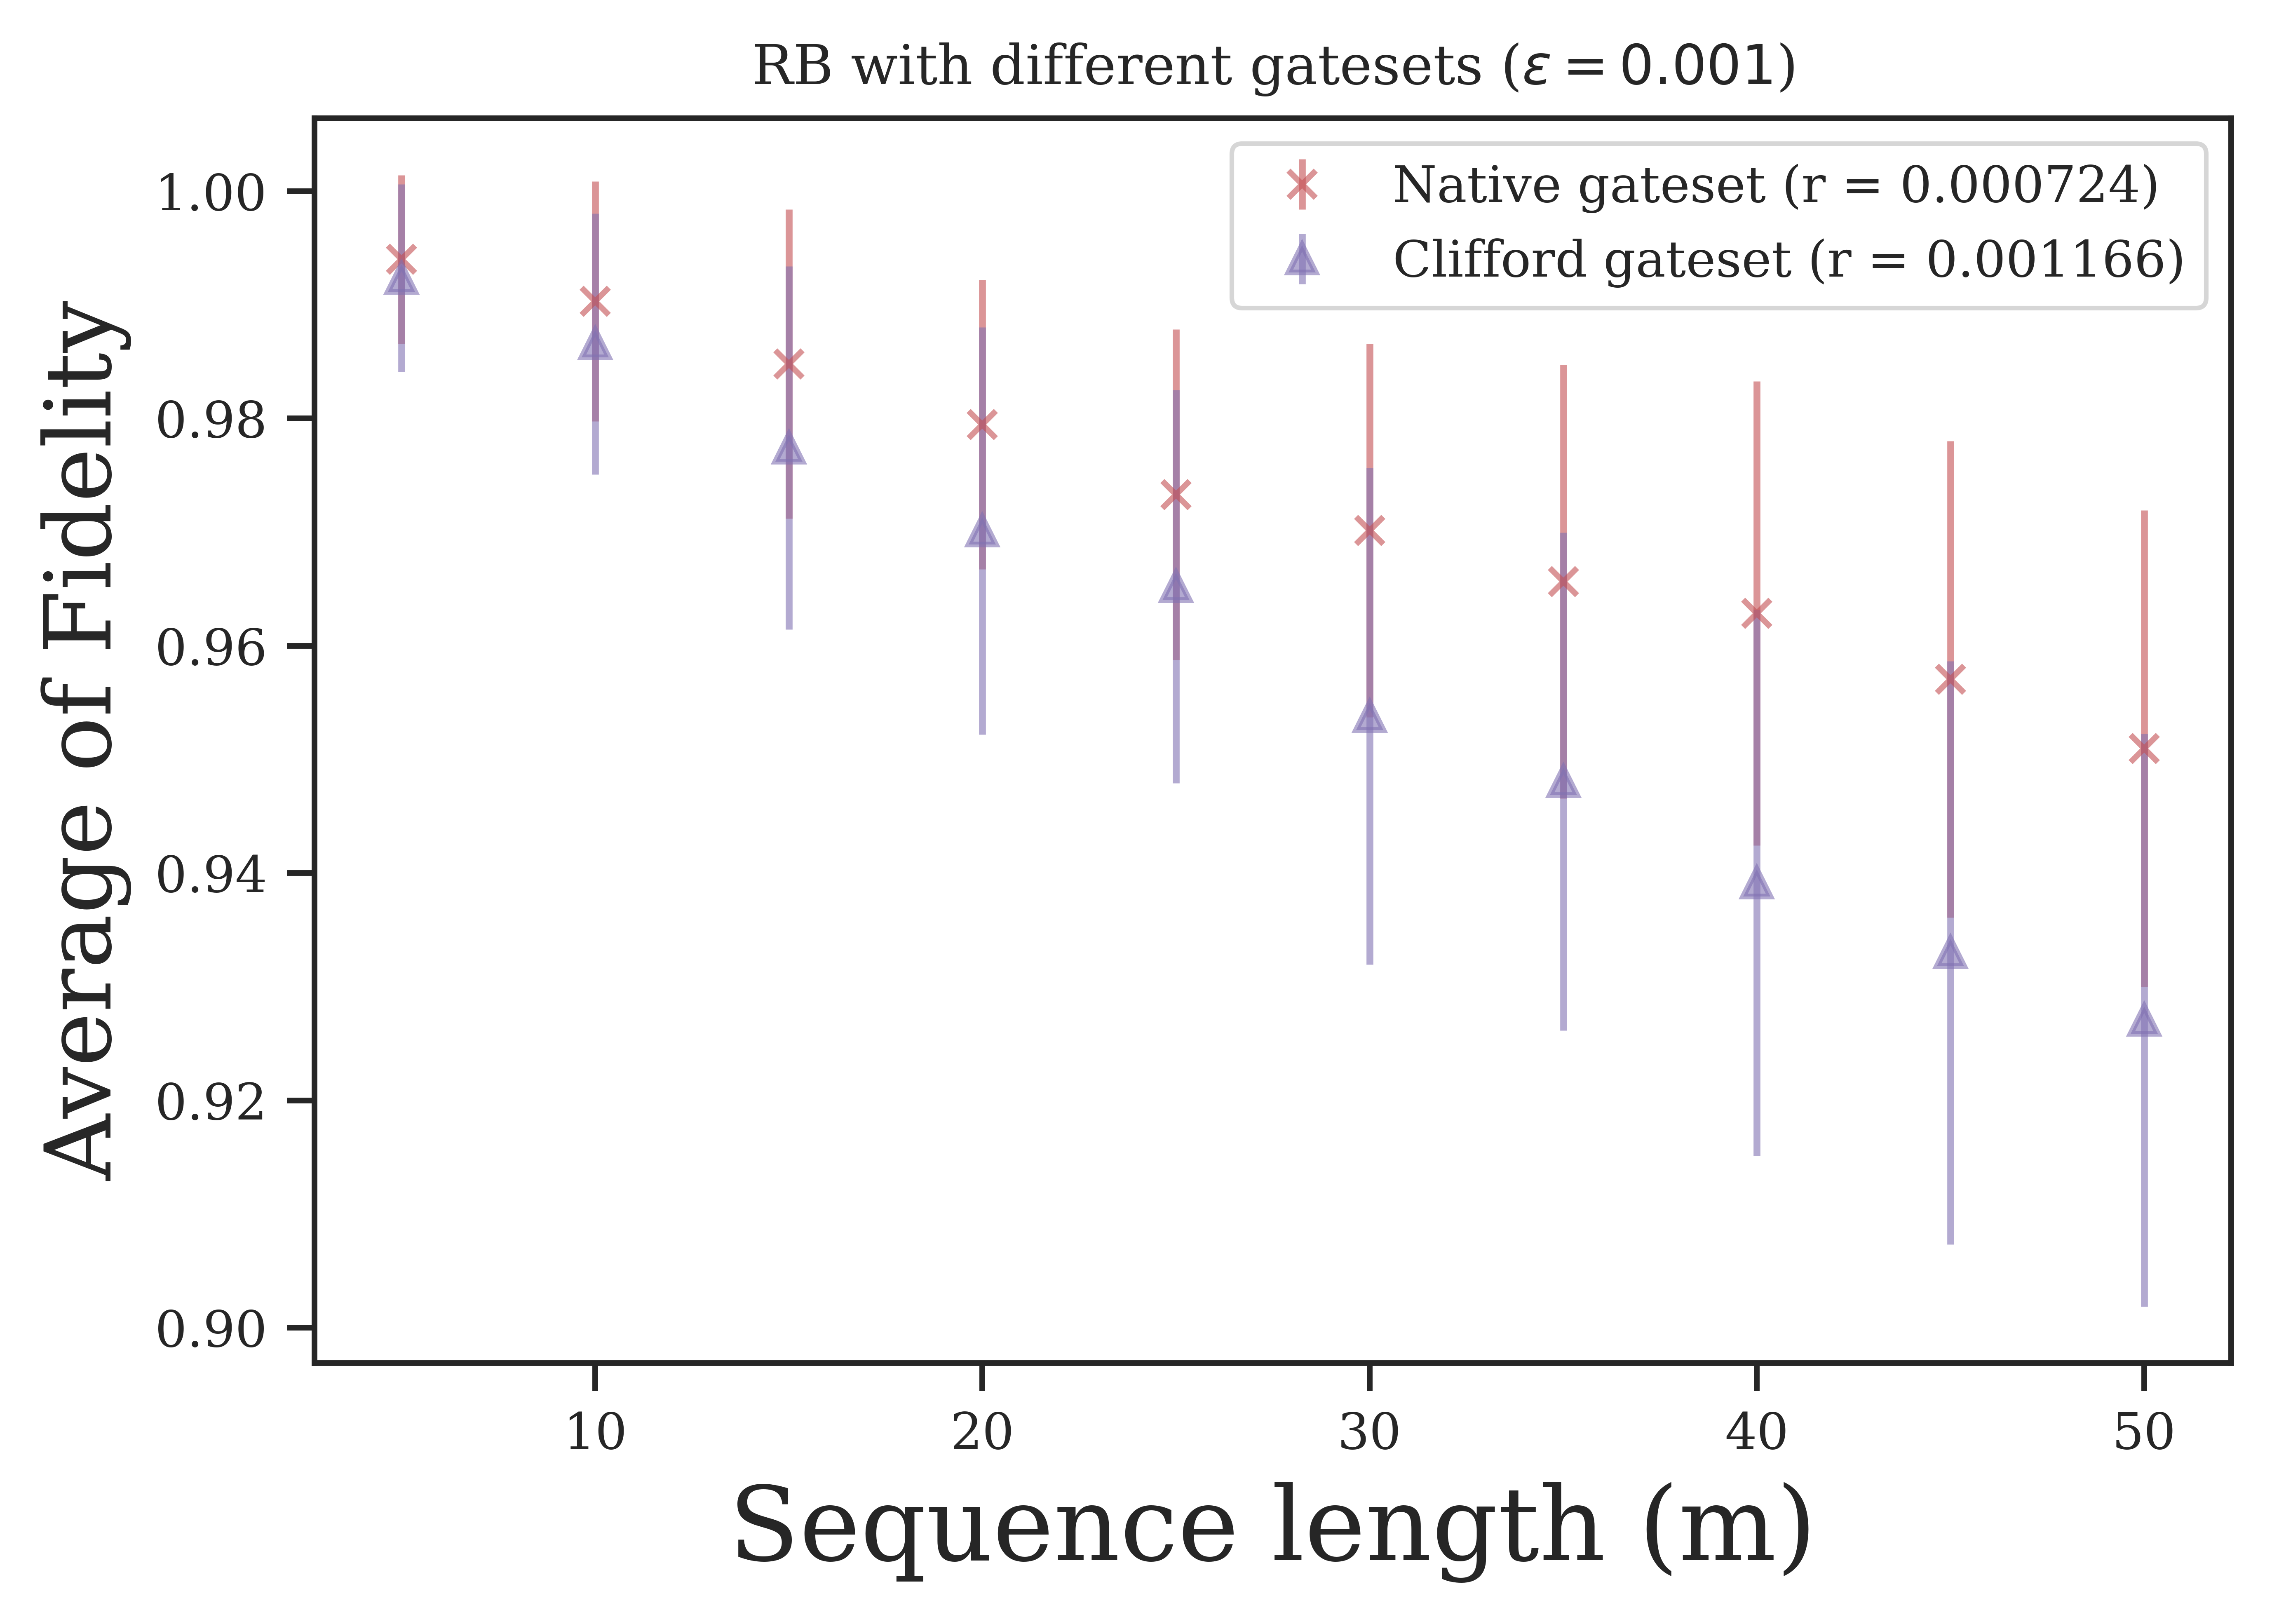

In [8]:
epsilon = 0.001
popt_std, pcov_std = curve_fit(decay_func, ordered_layers_dict[epsilon], avg_std_fdlty_dict[epsilon],
                               bounds=([0,0,-10], [1., 10., 0.]))
r_std = decay_param(popt_std[0], n_qubit)

popt_rng, pcov_rng = curve_fit(decay_func, ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon]
                               , bounds=([0,0,-10], [1., 10., 0.]))
r_rng = decay_param(popt_rng[0], n_qubit)

fig = plt.figure(dpi = 1000)
ax = fig.add_subplot()

# plt.loglog()

ax.errorbar(ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon], yerr = err_rng_fdlty_dict[epsilon],
            fmt='x',color = 'r', alpha = 0.6,
            label = 'Native gateset (r = {})'.format(np.round(r_rng,6)))
ax.errorbar(ordered_layers_dict[epsilon], avg_std_fdlty_dict[epsilon], yerr = err_std_fdlty_dict[epsilon],
            fmt = '^', color = 'm', alpha = 0.6,
            label = 'Clifford gateset (r = {})'.format(np.round(r_std,6)))

plt.xlabel('Sequence length (m)', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title(r'RB with different gatesets ($\epsilon = {}$)'.format(epsilon))

plt.legend()

# fig.savefig(os.path.join(path, 'RB_std_ntv_comparison_'+folder_name +'.png'))


In [9]:
def root_sum_squared(array_one, array_two):
    return np.sqrt( array_one**2 + array_two**2 )

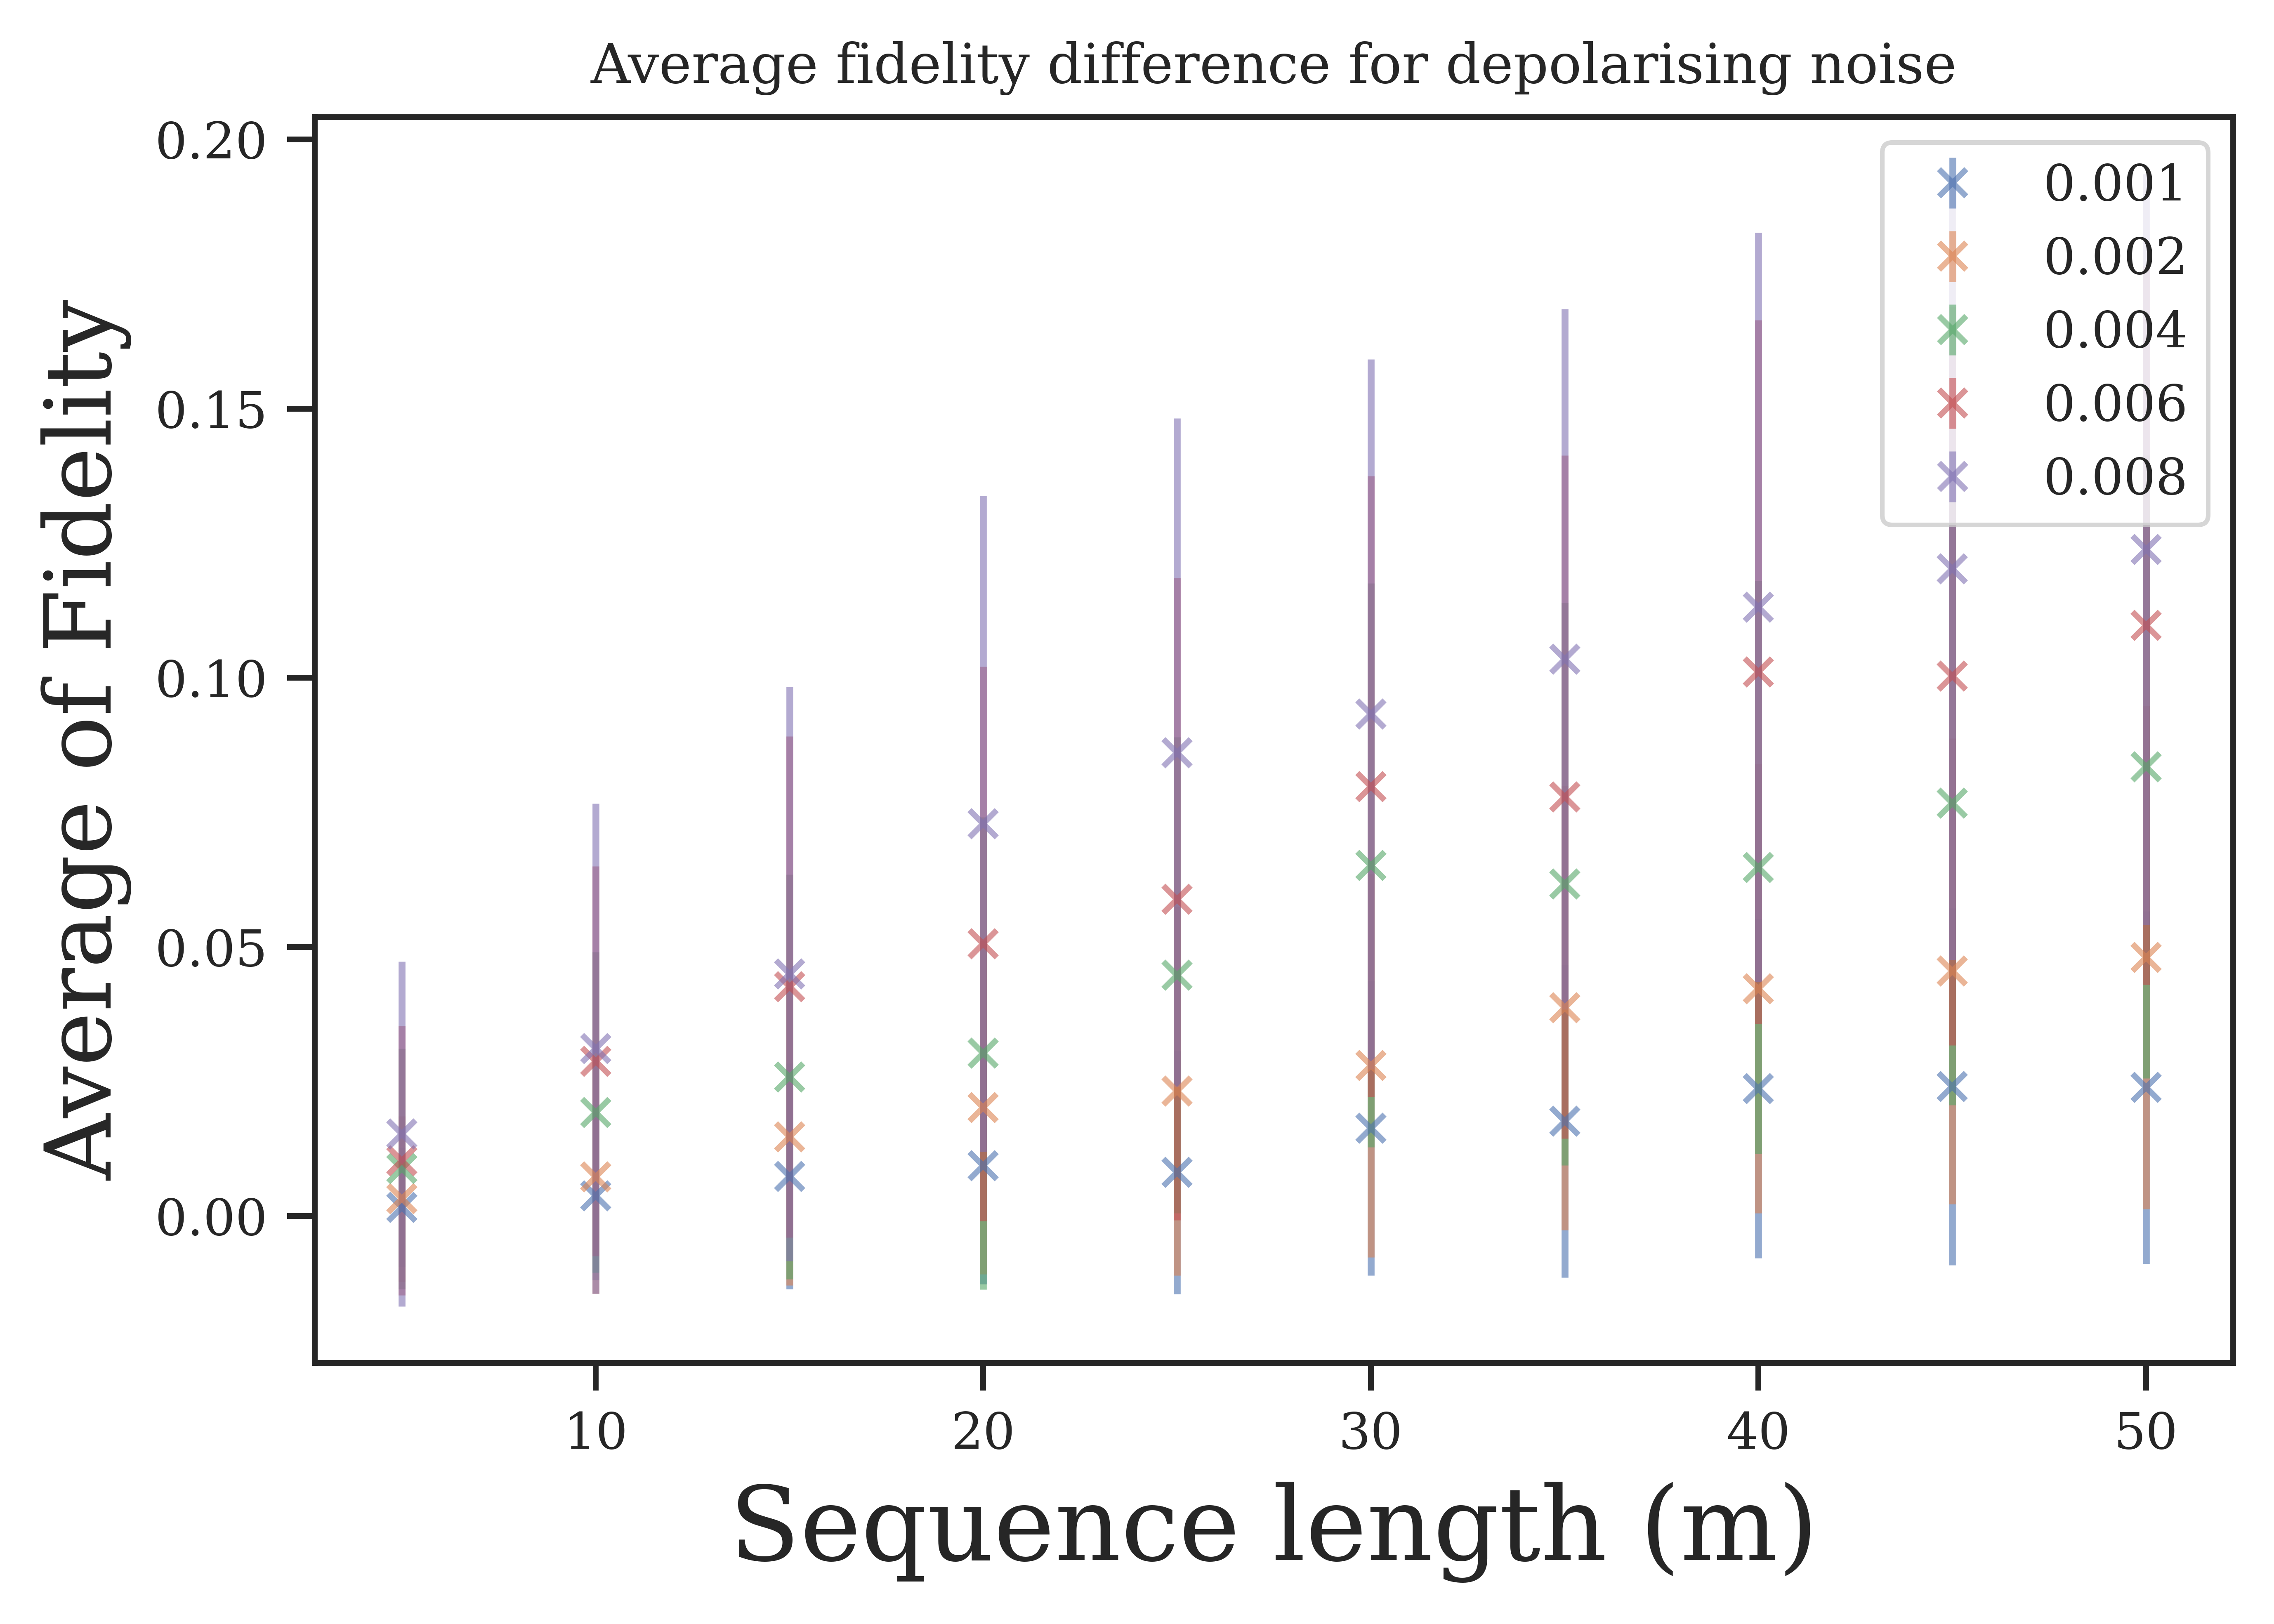

In [10]:
fig = plt.figure(dpi = 1000)
# fig = plt.figure()
ax = fig.add_subplot()

for epsilon in [0.001,0.002,0.004,0.006,0.008]:

    # plt.loglog()

    ax.errorbar(ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon] - avg_std_fdlty_dict[epsilon],
                yerr = root_sum_squared(err_rng_fdlty_dict[epsilon],err_std_fdlty_dict[epsilon]),
                alpha = 0.6, fmt='x',
                label = '{}'.format(epsilon))


plt.xlabel('Sequence length (m)', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title('Average fidelity difference for depolarising noise'.format(epsilon))

plt.legend()

# fig.savefig(os.path.join(path, 'RB_std_ntv_comparison_'+folder_name +'.png'))


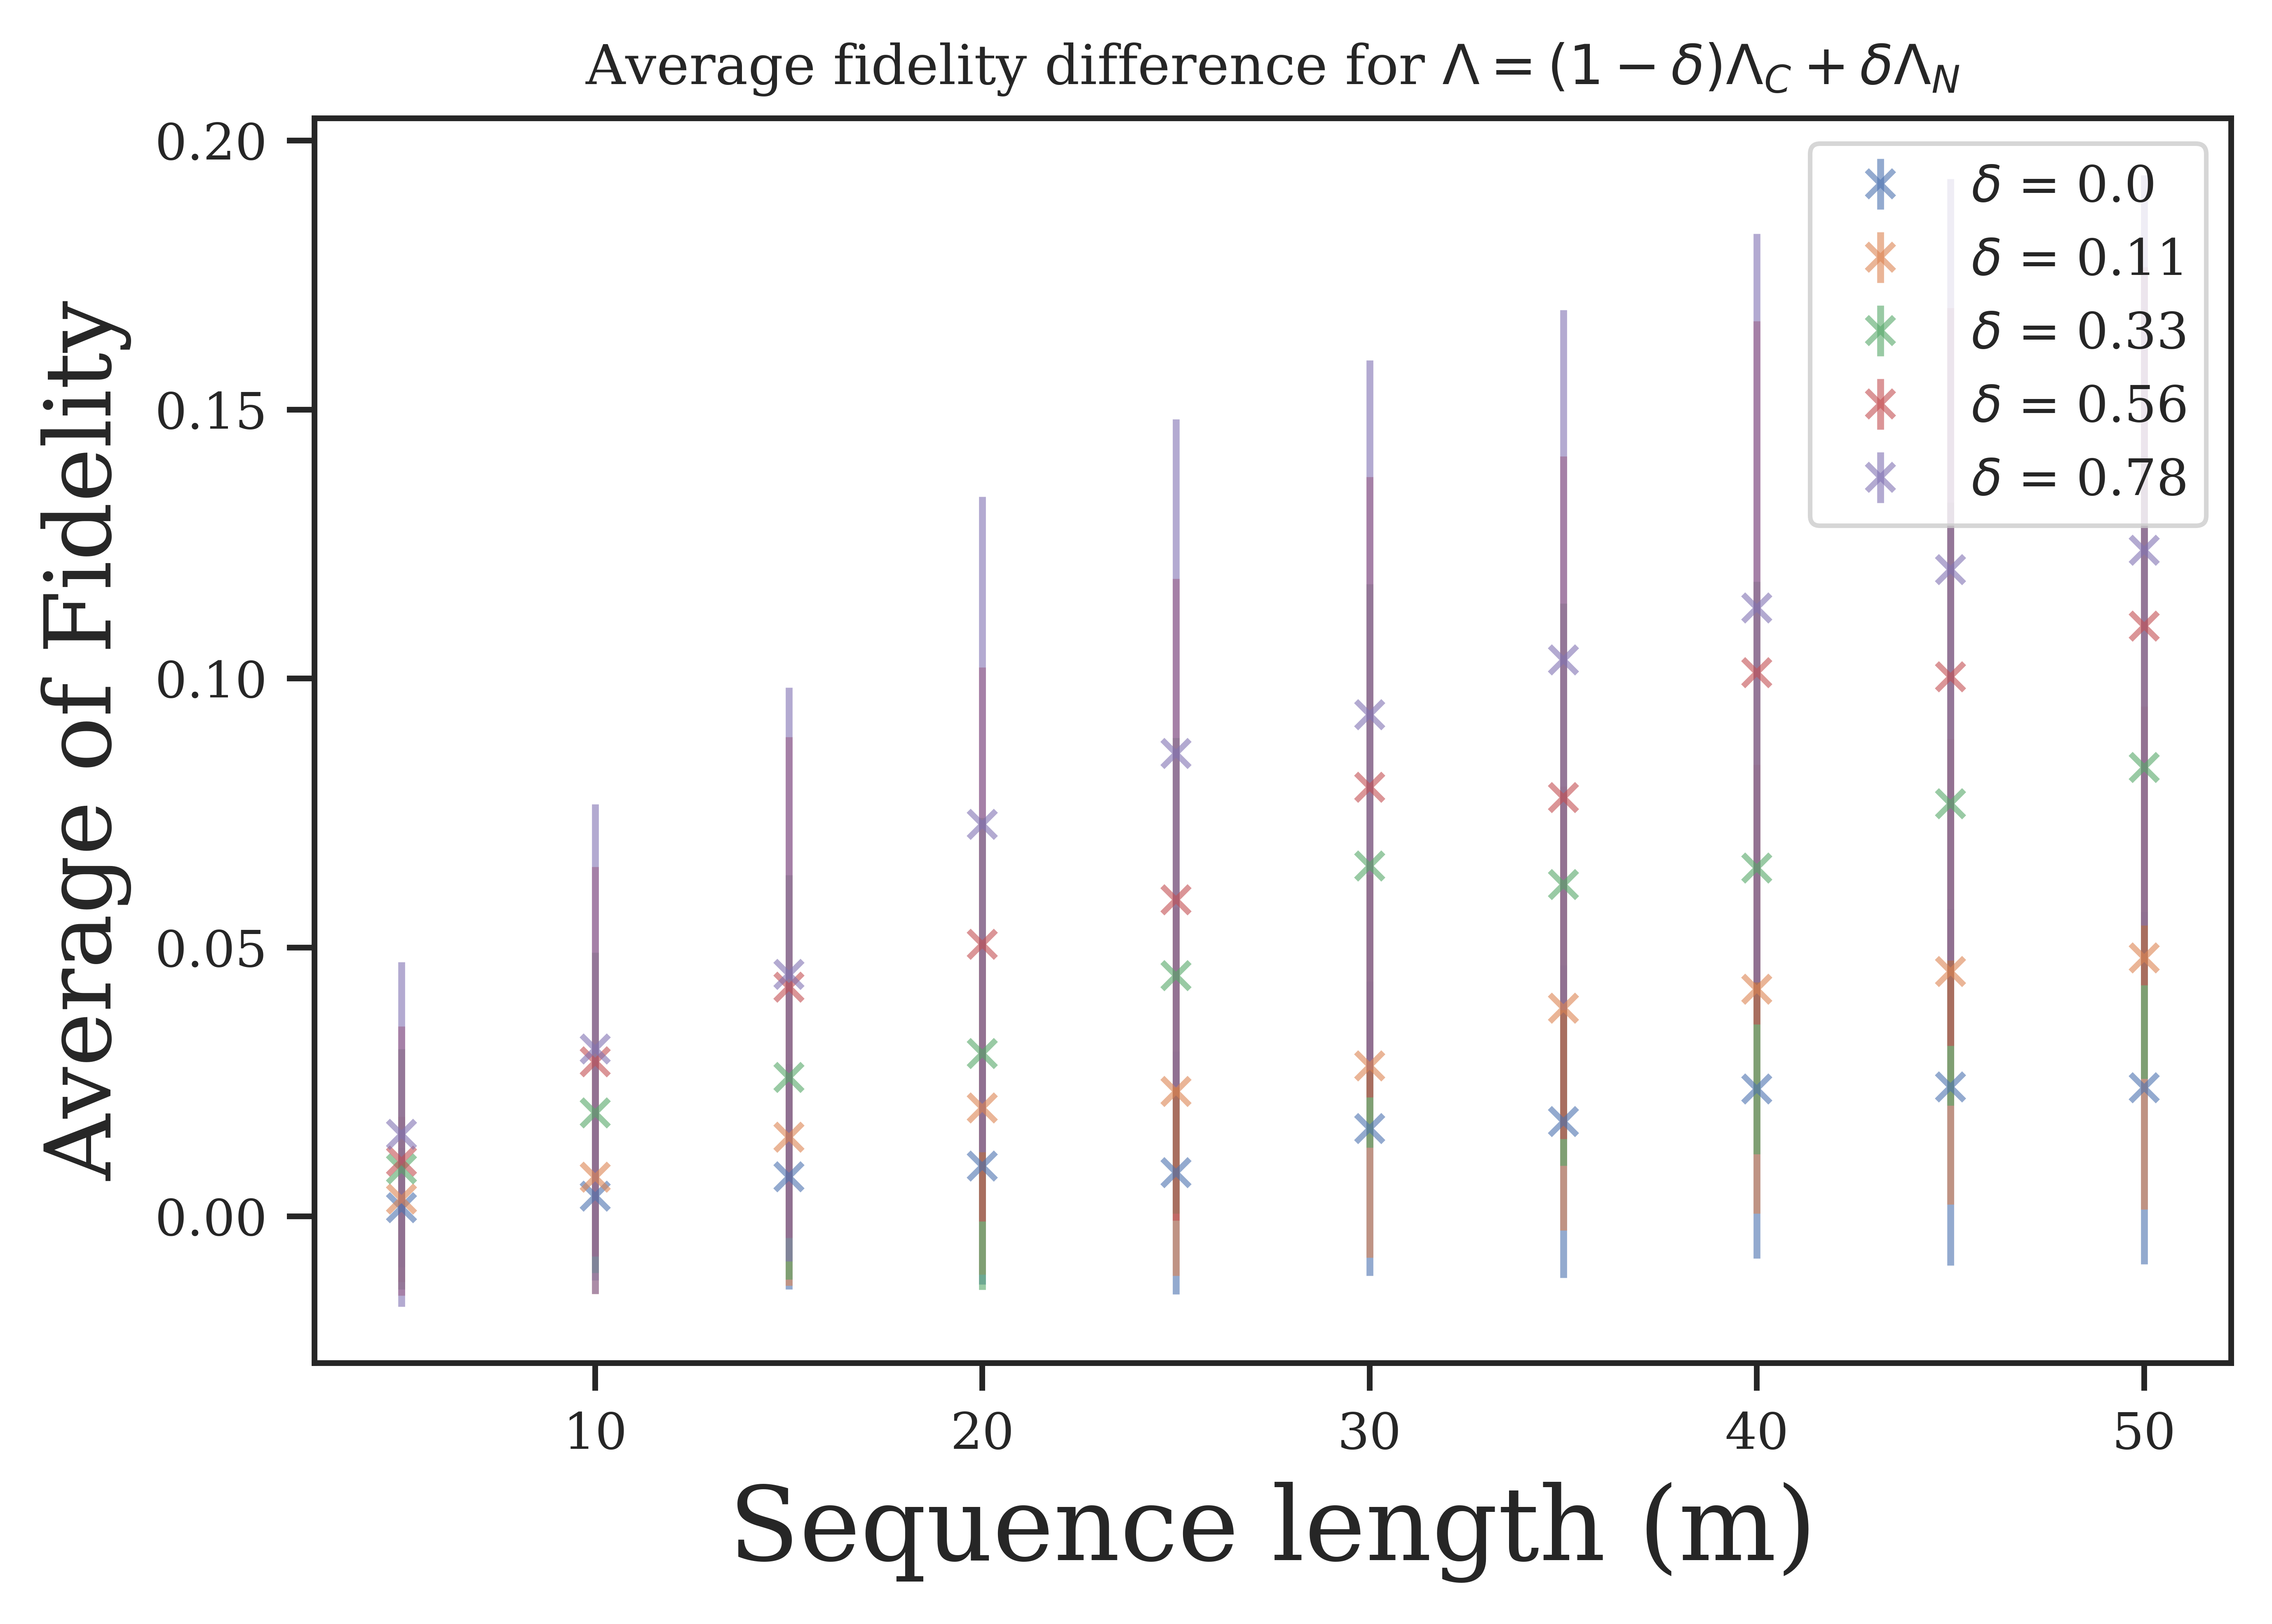

In [12]:
fig = plt.figure(dpi = 1000)
# fig = plt.figure()
ax = fig.add_subplot()

for epsilon in [0.001,0.002,0.004,0.006,0.008]:
    delta = (epsilon - 0.001)/0.009
    # plt.loglog()

    ax.errorbar(ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon] - avg_std_fdlty_dict[epsilon],
                yerr = root_sum_squared(err_rng_fdlty_dict[epsilon],err_std_fdlty_dict[epsilon]),
                alpha = 0.6, fmt='x',
                label = r'$\delta$ = {}'.format(np.round(delta,2)))


plt.xlabel('Sequence length (m)', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title(r'Average fidelity difference for $\Lambda = (1-\delta) \Lambda_C + \delta \Lambda_N$'.format(epsilon))

plt.legend()

fig.savefig(os.path.join(path, 'RB_combination_two_dep_noises.png'))


In [ ]:
fig = plt.figure(dpi = 1000)
# fig = plt.figure()
ax = fig.add_subplot()

for epsilon in [0.001,0.002,0.004,0.006,0.008]:
    delta = (epsilon - 0.001)/0.009
    # plt.loglog()

    ax.errorbar(ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon] - avg_std_fdlty_dict[epsilon],
                yerr = root_sum_squared(err_rng_fdlty_dict[epsilon],err_std_fdlty_dict[epsilon]),
                alpha = 0.6, fmt='x',
                label = r'$\delta$ = {}'.format(np.round(delta,2)))


plt.xlabel('Sequence length (m)', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title(r'Average fidelity difference for $\Lambda = (1-\delta) \Lambda_C + \delta \Lambda_N$'.format(epsilon))

plt.legend()

fig.savefig(os.path.join(path, 'RB_combination_two_dep_noises.png'))


In [17]:
avg_rng_fdlty_dict

{0.001: array([0.994  , 0.9903 , 0.9848 , 0.97945, 0.9733 , 0.97015, 0.96565,
        0.96285, 0.95705, 0.95095]),
 0.002: array([0.9893 , 0.98   , 0.97155, 0.96355, 0.95235, 0.94445, 0.9356 ,
        0.92625, 0.9181 , 0.9063 ]),
 0.004: array([0.97975, 0.96205, 0.93975, 0.9204 , 0.9093 , 0.8944 , 0.87385,
        0.85345, 0.84395, 0.8253 ]),
 0.006: array([0.96855, 0.94675, 0.91865, 0.8903 , 0.86   , 0.84315, 0.8166 ,
        0.7994 , 0.7766 , 0.7575 ]),
 0.008: array([0.96135, 0.9233 , 0.88575, 0.8605 , 0.83315, 0.80035, 0.7704 ,
        0.74495, 0.7211 , 0.69985])}